## healpix qe pixelisation issue 

In [3]:
import os
os.environ["DISABLE_MPI"]="true"
from falafel import utils as futils, qe
import numpy as np
from orphics import maps
import healpy as hp
from pixell import curvedsky, enmap, enplot
import matplotlib.pyplot as plt

Set some options for the reconstruction

In [4]:
lmin = 100
lmax = 2000
mlmax = 2500

In [5]:
# Set noise level and beam (this will enter into to the Cinv filter used for lensing reconstruction)
# we're not actually going to add noise to the simulation here
noise_sigma = 5. #muK
beam_fwhm=1.5 #arcmin
ells = np.arange(mlmax+1)
beam = maps.gauss_beam(ells, beam_fwhm)
Nl_tt = (noise_sigma*np.pi/180./60.)**2./beam**2
nells = {"TT":Nl_tt, "EE":2*Nl_tt, "BB":2*Nl_tt}

#use falafel to get theory Cls 
ucls,tcls = futils.get_theory_dicts(grad=True, nells=nells, lmax=mlmax)

Generate point-source map and convert to alm

In [6]:
nside=2048
nsource=10000
flux=50. #mJY

#assing to random pixels 
npix = hp.nside2npix(nside)
flux_density_map = np.zeros(hp.nside2npix(nside))
pixel_area = hp.nside2pixarea(nside)
source_pix = np.random.choice(np.arange(npix),size=nsource)
np.add.at(flux_density_map, source_pix, flux/pixel_area)
#flux_density_map is in mJY per sr
#convert to CMB temp units
def flux_density_to_temp(freq):
    #get factor for converting delta flux density in MJy/sr
    #to delta T in CMB units. freq in GHz
    freq = float(freq)
    x = freq / 56.8
    return (1.05e3 * (np.exp(x)-1)**2 *
            np.exp(-x) * (freq / 100)**-4)

source_temp_map = (flux_density_map / 1.e9) * flux_density_to_temp(150.)

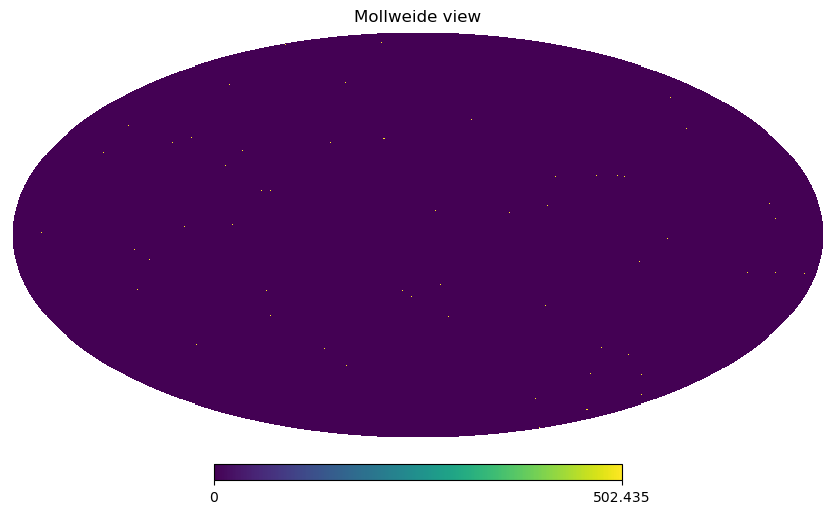

In [7]:
%matplotlib inline

hp.mollview(source_temp_map)

convert to alm and filter

In [8]:
fg_alm = hp.map2alm(source_temp_map, lmax=mlmax)

In [9]:
fg_alm_filtered = qe.filter_alms(fg_alm, 1./tcls["TT"] ,lmin=lmin,lmax=lmax)

Setup falafel pixelisation objects

In [10]:
px_hp = qe.pixelization(nside=2048)
shape, wcs = enmap.fullsky_geometry(res=np.radians(1. / 60.0))
px_car = qe.pixelization(shape, wcs)

And run source estimator with both pixelisations

In [ ]:
src_hp_nonorm = qe.qe_source(px_hp, mlmax, fg_alm_filtered,
                          xfTalm=fg_alm_filtered)
src_car_nonorm = qe.qe_source(px_car, mlmax, fg_alm_filtered,
                          xfTalm=fg_alm_filtered)

/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:147: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version
  if tweak: warnings.warn("The tweak argument is deprecated and does nothing after the libsharp→ducc transition. It will be removed in a future version")
/global/cfs/projectdirs/act/data/maccrann/lenspipe_new/lib/python3.10/site-packages/pixell/curvedsky.py:284: UserWarning: The tweak argument is deprecated and does nothing after the libsharp→ducc tr

Compare alm values with a scatter plot

In [ ]:
%matplotlib inline

fig,ax=plt.subplots()

ax.plot(src_hp_nonorm, src_car_nonorm, ',')
ax.set_ylim([-5.e5,5.e5])
ax.set_xlim([-5.e5,5.e5])

run source estimator